# This will perform a preliminary analysis to examine relationships between MUNI stop locations and trash complaints

### Takes two datasets from sfgov:
- MUNI data API endpoint: https://data.sfgov.org/resource/i28k-bkz6.json
- 311 data API endpoint: https://data.sfgov.org/resource/vw6y-z8j6.json
- Key Name: project311
- key ID: 1izx51hppbplpp02yd9r4gtlm
- Key Secret: 5ja9vkgnw7508zb1e1k29gsccgsgixp4xyg0t30b90jbgscsiq
- App token: vWmXiIsPgC3AdJZayzXihvrtP

In [3]:
import numpy as np
import pandas as pd

### Get data from APIs:

In [2]:
# Query TRASH 311 data:
app_token = 'vWmXiIsPgC3AdJZayzXihvrtP'
trash = pd.DataFrame()
total_entries = 100000
for offset in range(0,total_entries,1000):
    query = f"https://data.sfgov.org/resource/vw6y-z8j6.json?$$app_token={app_token}&$limit=1000&$offset={offset}&service_name=Street and Sidewalk Cleaning&service_subtype=City_garbage_can_overflowing"
    trash = trash.append(pd.read_json(query.replace(" ","%20")),ignore_index=True)

In [4]:
# Query MUNI data:
muni = pd.DataFrame()
total_entries = 5000
for offset in range(0,total_entries,1000):
    query = f"https://data.sfgov.org/resource/i28k-bkz6.json?$$app_token={app_token}&$limit=1000&$offset={offset}"
    muni = muni.append(pd.read_json(query))

# Calculate nearest MUNI location to each complaint (haversine metric):
### clean 311 trash data where no location was input:

In [5]:
# drop rows where there exist no location info:
trash.drop(trash[trash['lat']==0].index,inplace=True)
# Convert list of muni and trash complaints to radians:
muni_locations = muni[['latitude','longitude']].to_numpy()*(np.pi/180)
trash_locations = trash[['lat','long']].to_numpy()*(np.pi/180)

### Use nearest neighbor algorithm:

In [7]:
from sklearn.neighbors import BallTree
tree = BallTree(muni_locations, leaf_size=15,metric='haversine')
dist_to_muni = tree.query(trash_locations,k=1)

### Convert to miles and append to trash data frame:

In [8]:
EARTH_RADIUS = 3961 # miles
trash['nearest_muni'] = dist_to_muni[0]*EARTH_RADIUS

### Plot counts of complaint frequency and MUNI stop distance:

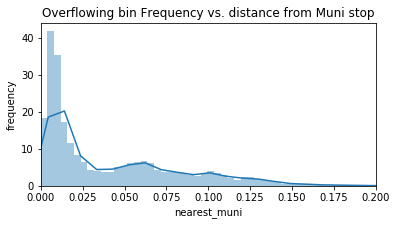

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.xlim(0,0.2)
plt.xlabel('Nearest Muni Stop (mi)')
plt.ylabel('frequency')
plt.title('Overflowing bin Frequency vs. distance from Muni stop')
sns.distplot(trash['nearest_muni'],bins=300)
plt.show()

### Some next steps:
- Should really get each trash bin and frequency as function of muni distance:
- Do closer bins tend to get complaints more often (more people to fill them?)
- Do closer muni stop trash cans get less complaints on weekends?
- Do we have data on muni line usage?
- Will need distance between all trash complaints: bimodal will show same vs. diffrent and help me decide on distance cutoff
